In [89]:
import os
os.chdir('/content/drive/My Drive/google_project/interview_data')
! ls

 annotations			      model_helmet.h5
 annotations.xml		      model_helmet.json
 darknet			      model_mask.h5
 dataset.csv			      model_mask.json
 final				      MyFile.txt
'Integrating_yolo&NN_models.ipynb'    YOLO_Training.ipynb
 interview_data			      Yoo_Data_Generation.ipynb
'Mask&Helmet_models_training.ipynb'


In [0]:
import numpy as np
import argparse
import time
import cv2
import os

# Loading the YOLO V3 model

In [91]:
labelsPath = os.path.sep.join(['darknet/data', "obj.names"])
labelsPath

'darknet/data/obj.names'

In [0]:
LABELS = open(labelsPath).read().strip().split("\n")
# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

In [93]:
# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join(['darknet/backup', "yolo-obj_last.weights"])
configPath = os.path.sep.join(['darknet', "yolo-obj.cfg"])
# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)


[INFO] loading YOLO from disk...


# Loading mask model

In [0]:
import tensorflow as tf

In [95]:
json_mask = open('model_mask.json', 'r')
loaded_model_mask = json_mask.read()
json_mask.close()
model_mask = tf.keras.models.model_from_json(loaded_model_mask)
# load weights into new model
model_mask.load_weights("model_mask.h5")
print("Loaded model mask from disk")

Loaded model mask from disk


In [0]:
labels_mask = {0: 'invisible', 1: 'no', 2: 'wrong', 3: 'yes'}

# Loading Helmet model

In [97]:
json_helmet = open('model_helmet.json', 'r')
loaded_model_helmet = json_helmet.read()
json_helmet.close()
model_helmet = tf.keras.models.model_from_json(loaded_model_helmet)
# load weights into new model
model_helmet.load_weights("model_helmet.h5")
print("Loaded helmet model from disk")

Loaded helmet model from disk


In [0]:
labels_helmet = {0: 'no', 1: 'yes'}

# For testing purposes i am taking image as input we can take live frames also for this

In [0]:
image_test = cv2.imread('darknet/test_image.jpg')

In [0]:
# load our input image and grab its spatial dimensions

(H, W) = image_test.shape[:2]
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(image_test, 1 / 255.0, (416, 416),
	swapRB=True, crop=False)
net.setInput(blob)
layerOutputs = net.forward(ln)

In [0]:
# initialize our lists of detected bounding boxes, confidences, and
# class IDs, respectively
boxes = []
confidences = []
classIDs = []

In [0]:
# loop over each of the layer outputs
for output in layerOutputs:
	# loop over each of the detections
	for detection in output:
		# extract the class ID and confidence (i.e., probability) of
		# the current object detection
		scores = detection[5:]
		classID = np.argmax(scores)
		confidence = scores[classID]
		# filter out weak predictions by ensuring the detected
		# probability is greater than the minimum probability
		if confidence > 0.5:
			# scale the bounding box coordinates back relative to the
			# size of the image, keeping in mind that YOLO actually
			# returns the center (x, y)-coordinates of the bounding
			# box followed by the boxes' width and height
			box = detection[0:4] * np.array([W, H, W, H])
			(centerX, centerY, width, height) = box.astype("int")
			# use the center (x, y)-coordinates to derive the top and
			# and left corner of the bounding box
			x = int(centerX - (width / 2))
			y = int(centerY - (height / 2))
			# update our list of bounding box coordinates, confidences,
			# and class IDs
			boxes.append([x, y, int(width), int(height)])
			confidences.append(float(confidence))
			classIDs.append(classID)

In [0]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5,0.3)

In [173]:
from keras.preprocessing import image
x = image.img_to_array(resized)
if len(idxs) > 0:
  for i in idxs.flatten():
    try:
      (x, y) = (boxes[i][0], boxes[i][1])
      (w, h) = (boxes[i][2], boxes[i][3])

      crop_image = image_test[y:y+h, x:x+w]
      dim = (64, 64)
      crop_image = cv2.resize(crop_image, dim, interpolation = cv2.INTER_AREA)
      image_array = image.img_to_array(crop_image)
      image_array = np.expand_dims(image_array, axis=0)
      mask_array = model_mask.predict(image_array)
      helmet_array = model_helmet.predict(image_array)
      print(helmet_array, mask_array)
      mask = np.argmax(mask_array)
      if helmet_array[0][0] > 0.5:  
        helmet = 1
      else:
        helmet = 0
      color = color = (0, 0, 0)
      cv2.rectangle(image_test, (x, y), (x + w, y + h), color, 2)
      text = "mask:{} helmet:{}".format(labels_mask[mask], labels_helmet[helmet])
      cv2.putText(image_test, text, (x, y + h + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    except:
      pass
    

[[1.]] [[2.7372526e-29 1.0000000e+00 0.0000000e+00 3.1873963e-19]]
[[1.]] [[0. 0. 0. 1.]]


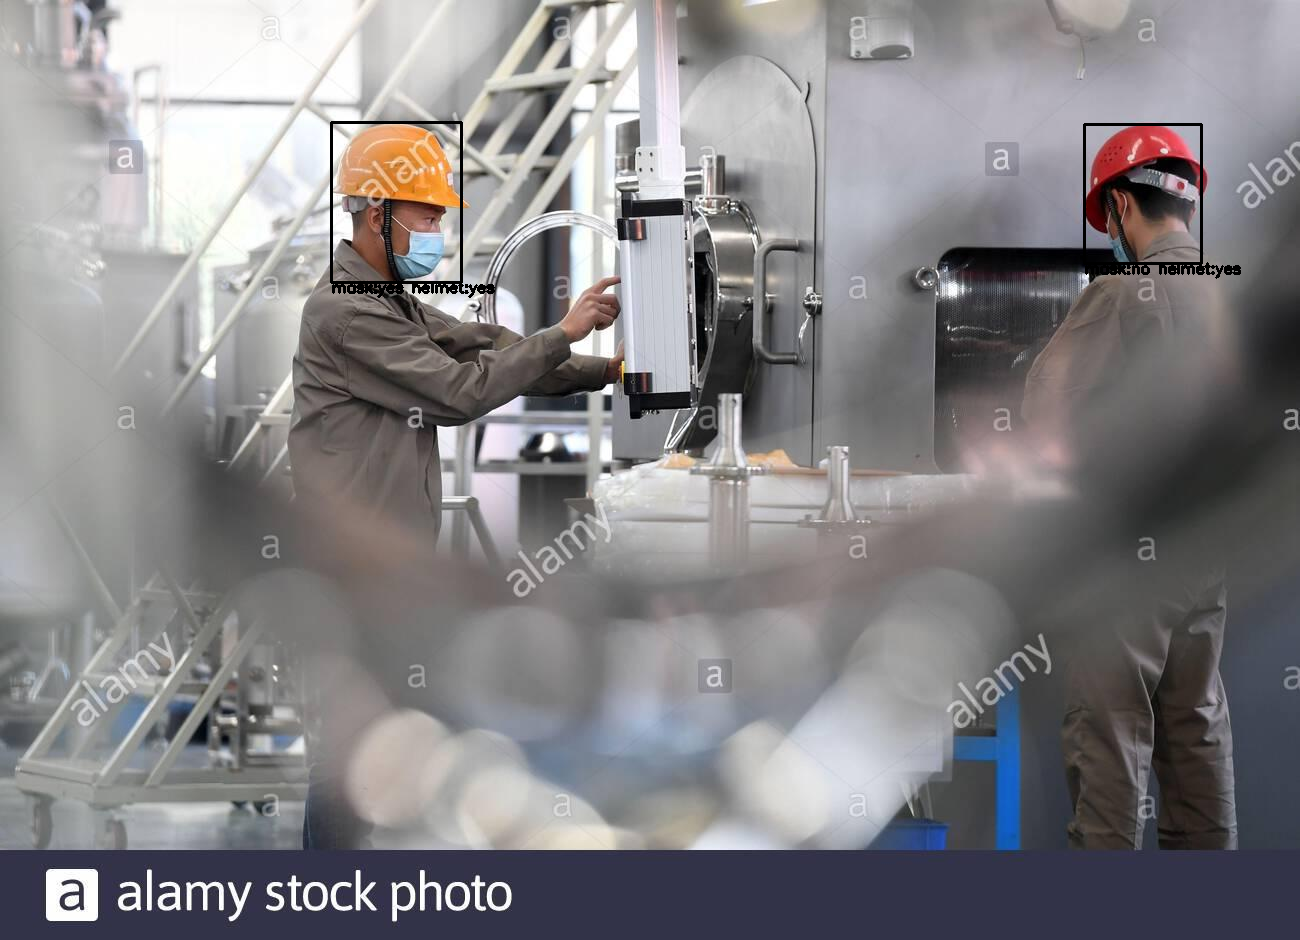

In [174]:
cv2_imshow(image_test)